# 04 분류하는 뉴런을 만듭니다

이 노트북을 주피터 노트북 뷰어(nbviewer.jupyter.org)로 보거나 구글 코랩(colab.research.google.com)에서 실행할 수 있습니다.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.org/github/rickiepark/do-it-dl/blob/master/Ch04.ipynb"><img src="https://jupyter.org/assets/share.png" width="60" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/do-it-dl/blob/master/Ch04.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

## 04-2 시그모이드 함수를 알아봅니다

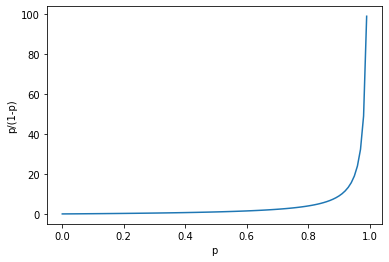

In [2]:
probs = np.arange(0, 1, 0.01)
odds = [p/(1-p) for p in probs]
plt.plot(probs, odds)
plt.xlabel('p')
plt.ylabel('p/(1-p)')
plt.show()

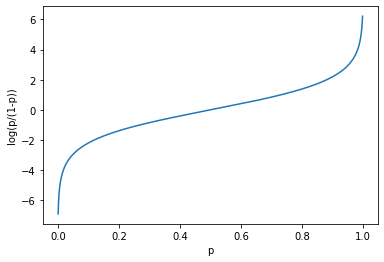

In [3]:
probs  = np.arange(0.001, 0.999, 0.001)
logit = [np.log(p/(1-p)) for p in probs]
plt.plot(probs, logit)
plt.xlabel('p')
plt.ylabel('log(p/(1-p))')
plt.show()

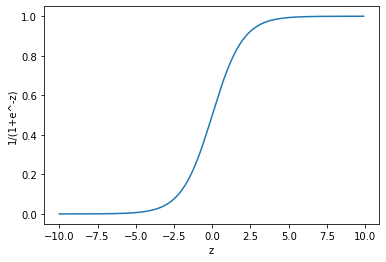

In [4]:
zs = np.arange(-10., 10., 0.1)
gs = [1/(1+np.exp(-z)) for z in zs]
plt.plot(zs, gs)
plt.xlabel('z')
plt.ylabel('1/(1+e^-z)')
plt.show()

## 04-4 분류용 데이터셋을 준비합니다

In [5]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

In [6]:
print(cancer.data.shape, cancer.target.shape)

(569, 30) (569,)


In [7]:
cancer.data[:3]

array([[1.799e+01, 1.038e+01, 1.228e+02, 1.001e+03, 1.184e-01, 2.776e-01,
        3.001e-01, 1.471e-01, 2.419e-01, 7.871e-02, 1.095e+00, 9.053e-01,
        8.589e+00, 1.534e+02, 6.399e-03, 4.904e-02, 5.373e-02, 1.587e-02,
        3.003e-02, 6.193e-03, 2.538e+01, 1.733e+01, 1.846e+02, 2.019e+03,
        1.622e-01, 6.656e-01, 7.119e-01, 2.654e-01, 4.601e-01, 1.189e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, 1.326e+03, 8.474e-02, 7.864e-02,
        8.690e-02, 7.017e-02, 1.812e-01, 5.667e-02, 5.435e-01, 7.339e-01,
        3.398e+00, 7.408e+01, 5.225e-03, 1.308e-02, 1.860e-02, 1.340e-02,
        1.389e-02, 3.532e-03, 2.499e+01, 2.341e+01, 1.588e+02, 1.956e+03,
        1.238e-01, 1.866e-01, 2.416e-01, 1.860e-01, 2.750e-01, 8.902e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, 1.203e+03, 1.096e-01, 1.599e-01,
        1.974e-01, 1.279e-01, 2.069e-01, 5.999e-02, 7.456e-01, 7.869e-01,
        4.585e+00, 9.403e+01, 6.150e-03, 4.006e-02, 3.832e-02, 2.058e-02,
        2.250e-02, 4.571e-03, 2.357e

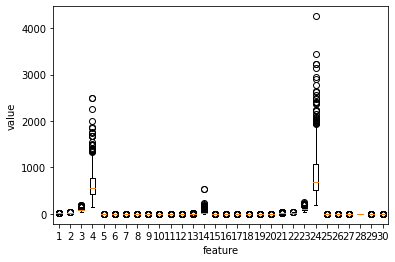

In [8]:
plt.boxplot(cancer.data)
plt.xlabel('feature')
plt.ylabel('value')
plt.show()

In [9]:
cancer.feature_names[[3,13,23]]

array(['mean area', 'area error', 'worst area'], dtype='<U23')

In [10]:
np.unique(cancer.target, return_counts=True)

(array([0, 1]), array([212, 357]))

In [11]:
x = cancer.data
y = cancer.target

## 04-5 로지스틱 회귀로 모델을 만들어봅니다

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, 
                                                    test_size=0.2, random_state=42)

In [14]:
print(x_train.shape, x_test.shape)

(455, 30) (114, 30)


In [15]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([170, 285]))

In [16]:
class LogisticNeuron:
    
    def __init__(self):
        self.w = None
        self.b = None

    def forpass(self, x):
        z = np.sum(x * self.w) + self.b  # 직선 방정식을 계산합니다
        return z

    def backprop(self, x, err):
        w_grad = x * err    # 가중치에 대한 그래디언트를 계산합니다
        b_grad = 1 * err    # 절편에 대한 그래디언트를 계산합니다
        return w_grad, b_grad

    def activation(self, z):
        z = np.clip(z, -100, None) # 안전한 np.exp() 계산을 위해
        a = 1 / (1 + np.exp(-z))  # 시그모이드 계산
        return a
        
    def fit(self, x, y, epochs=100):
        self.w = np.ones(x.shape[1])      # 가중치를 초기화합니다.
        self.b = 0                        # 절편을 초기화합니다.
        for i in range(epochs):           # epochs만큼 반복합니다
            for x_i, y_i in zip(x, y):    # 모든 샘플에 대해 반복합니다
                z = self.forpass(x_i)     # 정방향 계산
                a = self.activation(z)    # 활성화 함수 적용
                err = -(y_i - a)          # 오차 계산
                w_grad, b_grad = self.backprop(x_i, err) # 역방향 계산
                self.w -= w_grad          # 가중치 업데이트
                self.b -= b_grad          # 절편 업데이트
    
    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]    # 정방향 계산
        a = self.activation(np.array(z))        # 활성화 함수 적용
        return a > 0.5

In [17]:
a = np.array([1,2,3])
b = np.array([3,4,5])

In [18]:
a + b

array([4, 6, 8])

In [19]:
a * b

array([ 3,  8, 15])

In [20]:
np.sum(a * b)

26

In [21]:
np.zeros((2, 3))

array([[0., 0., 0.],
       [0., 0., 0.]])

In [22]:
np.full((2,3), 7)

array([[7, 7, 7],
       [7, 7, 7]])

In [23]:
np.c_[np.zeros((2,3)), np.ones((2,3))]

array([[0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1.]])

In [24]:
neuron = LogisticNeuron()
neuron.fit(x_train, y_train)

In [25]:
np.mean(neuron.predict(x_test) == y_test)

0.8245614035087719

## 04-6 단일층 신경망을 만들어 봅니다

In [26]:
class SingleLayer:
    
    def __init__(self):
        self.w = None
        self.b = None
        self.losses = []

    def forpass(self, x):
        z = np.sum(x * self.w) + self.b  # 직선 방정식을 계산합니다
        return z

    def backprop(self, x, err):
        w_grad = x * err    # 가중치에 대한 그래디언트를 계산합니다
        b_grad = 1 * err    # 절편에 대한 그래디언트를 계산합니다
        return w_grad, b_grad

    def activation(self, z):
        z = np.clip(z, -100, None) # 안전한 np.exp() 계산을 위해
        a = 1 / (1 + np.exp(-z))  # 시그모이드 계산
        return a
        
    def fit(self, x, y, epochs=100):
        self.w = np.ones(x.shape[1])               # 가중치를 초기화합니다.
        self.b = 0                                 # 절편을 초기화합니다.
        for i in range(epochs):                    # epochs만큼 반복합니다
            loss = 0
            # 인덱스를 섞습니다
            indexes = np.random.permutation(np.arange(len(x)))
            for i in indexes:                      # 모든 샘플에 대해 반복합니다
                z = self.forpass(x[i])             # 정방향 계산
                a = self.activation(z)             # 활성화 함수 적용
                err = -(y[i] - a)                  # 오차 계산
                w_grad, b_grad = self.backprop(x[i], err) # 역방향 계산
                self.w -= w_grad                   # 가중치 업데이트
                self.b -= b_grad                   # 절편 업데이트
                # 안전한 로그 계산을 위해 클리핑한 후 손실을 누적합니다
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))
            # 에포크마다 평균 손실을 저장합니다
            self.losses.append(loss/len(y))
    
    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]     # 정방향 계산
        return np.array(z) > 0                   # 스텝 함수 적용
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)

In [27]:
layer = SingleLayer()
layer.fit(x_train, y_train)
layer.score(x_test, y_test)

0.9298245614035088

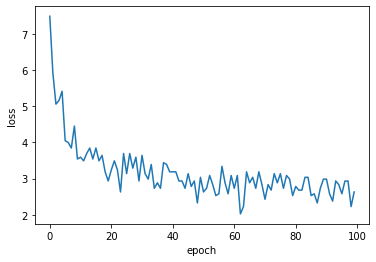

In [28]:
plt.plot(layer.losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 04-7 사이킷런의 경사 하강법을 사용해 봅니다

In [29]:
from sklearn.linear_model import SGDClassifier

In [30]:
sgd = SGDClassifier(loss='log', max_iter=100, tol=1e-3, random_state=42)
sgd.fit(x_train, y_train)
sgd.score(x_test, y_test)

0.8333333333333334

In [31]:
sgd.predict(x_test[0:10])

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0])